In [1]:
import pandas as pd
import numpy as np

In [2]:
def load_and_clean_data(filepath, drop_cols=None, start_date="1963-01-01"):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(filepath, index_col=0, parse_dates=True)
    if drop_cols:
        df.drop(columns=drop_cols, inplace=True)
    df.dropna(inplace=True)
    return df.loc[start_date:].copy()

sp500 = load_and_clean_data("data/sp_daily.csv")
rf = load_and_clean_data("data/fama_daily.csv", drop_cols=['mktrf', 'smb', 'hml', 'umd'])

# Combine the two DataFrames on their index
df = sp500.join(rf, how='inner')


df

,spindx,sprtrn,rf
caldt,,,
1963-01-02,62.69,-0.006498,0.00011
1963-01-03,63.72,0.016430,0.00011
1963-01-04,64.13,0.006434,0.00011
1963-01-07,64.12,-0.000156,0.00011
1963-01-08,64.74,0.009669,0.00011
...,...,...,...
2024-12-24,6040.04,0.011043,0.00017
2024-12-26,6037.59,-0.000406,0.00017
2024-12-27,5970.84,-0.011056,0.00017


<Axes: xlabel='caldt'>

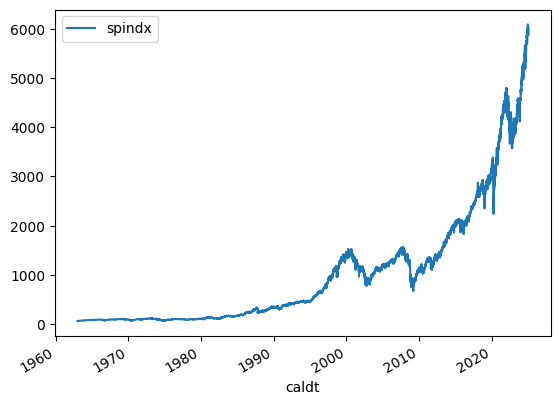

In [3]:
df.plot.line(y="spindx", use_index=True)

Compute log returns for simpler calculations in the future

In [4]:
# Convert simple S&P500 returns to log returns
df['sp_log_rtrn'] = np.log(1 + df['sprtrn'])

# Convert risk-free rate to log returns
df['rf_log_rtrn'] = np.log(1 + df['rf'])

# Calculate the excess log return
df['excess_log_rtrn'] = df['sp_log_rtrn'] - df['rf_log_rtrn']

# Optionally, drop the first row if you do not need the NaN value that results from the difference
df.dropna(inplace=True)

df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn
caldt,,,,,,
1963-01-02,62.69,-0.006498,0.00011,-0.006519,0.00011,-0.006629
1963-01-03,63.72,0.016430,0.00011,0.016296,0.00011,0.016186
1963-01-04,64.13,0.006434,0.00011,0.006413,0.00011,0.006303
1963-01-07,64.12,-0.000156,0.00011,-0.000156,0.00011,-0.000266
1963-01-08,64.74,0.009669,0.00011,0.009623,0.00011,0.009513
...,...,...,...,...,...,...
2024-12-24,6040.04,0.011043,0.00017,0.010982,0.00017,0.010812
2024-12-26,6037.59,-0.000406,0.00017,-0.000406,0.00017,-0.000576
2024-12-27,5970.84,-0.011056,0.00017,-0.011118,0.00017,-0.011288


Compute Standard deviation and expected returns with a rolling window

In [5]:
horizon = 2500

rolling_var = df["sp_log_rtrn"].rolling(horizon).var()
rolling_expected_rtrn = df["sp_log_rtrn"].rolling(horizon).mean()
rolling_expected_rf = df["rf_log_rtrn"].rolling(horizon).mean()

df['rolling_var'] = rolling_var
df['rolling_expected_rtrn'] = rolling_expected_rtrn
df['rolling_expected_rf'] = rolling_expected_rf  

Create a target variable by comparing if the S&P 500 of the risk-free rate will have a better performance during the next 3 months.

In [6]:
# Define the forward-looking window (e.g., 63 trading days for about 3 months)
window = 63

# Compute the forward cumulative log returns using a reversed rolling sum:
df['sp_cum_log_rtrn'] = df['sp_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1]
df['rf_cum_log_rtrn'] = df['rf_log_rtrn'][::-1].rolling(window=window, min_periods=window).sum()[::-1]

# Create the Target variable: 1 if the S&P 500 cumulative log return is higher than the risk-free rate, else 0
df['Target'] = (df['sp_cum_log_rtrn'] > df['rf_cum_log_rtrn']).astype(int)

# remove columns with missing values
df.dropna(inplace=True)


# Optional: inspect the resulting DataFrame
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,rf_cum_log_rtrn,Target
caldt,,,,,,,,,,,,
1973-01-10,119.43,-0.002506,0.00021,-0.002509,0.00021,-0.002719,0.000037,0.000255,0.000180,-0.064867,0.013768,0
1973-01-11,120.24,0.006782,0.00021,0.006759,0.00021,0.006549,0.000037,0.000261,0.000180,-0.058178,0.013818,0
1973-01-12,119.30,-0.007818,0.00021,-0.007849,0.00021,-0.008059,0.000037,0.000251,0.000181,-0.065824,0.013868,0
1973-01-15,118.44,-0.007209,0.00021,-0.007235,0.00021,-0.007445,0.000037,0.000245,0.000181,-0.062427,0.013918,0
1973-01-16,118.14,-0.002533,0.00021,-0.002536,0.00021,-0.002746,0.000037,0.000244,0.000181,-0.060918,0.013968,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000127,0.000442,0.000062,0.054046,0.011399,1
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000127,0.000434,0.000062,0.049610,0.011369,1
2024-09-30,5762.48,0.004237,0.00020,0.004228,0.00020,0.004028,0.000127,0.000438,0.000062,0.039746,0.011339,1


Check if the training window contains both cases (0 and 1) as Target Variables

In [7]:
window = 750
invalid_window_found = False  # flag to track if any window is missing a class

# Slide the window one step at a time
for i in range(len(df) - window + 1):
    window_values = df['Target'].iloc[i:i+window].values
    
    # Check if this window does NOT contain both 0 and 1
    if not (0 in window_values and 1 in window_values):
        invalid_window_found = True
        break  # no need to test further if one invalid window is found

print(invalid_window_found)


False


## Add Technical Indicators

Average Price (Moving Average)

In [8]:
new_predictors = []

ma_horizons = [4, 21, 55]

for horizon in ma_horizons:
    rolling_means = df["spindx"].rolling(horizon).mean()
    ratio_column = f"ma_ratio_{horizon}"
    df[ratio_column] = df["spindx"] / rolling_means  # Use the Series directly

    new_predictors += [ratio_column]



Volatility

In [9]:
# Compute the 10-day volatility (rolling standard deviation)
df['volatility_10'] = df['spindx'].rolling(window=10).std()

# Optionally, add this new predictor to your predictors list
new_predictors.append('volatility_10')


Moving average convergence divergence (MACD)

In [10]:
# set parameters
n = 42 # slow EMA
m = 21 # fast EMA
p = 14  # signal line

# Calculate EMAs
df[f'slow_EMA_{n}'] = df['spindx'].ewm(span=n, adjust=False).mean()
df[f'fast_EMA_{m}'] = df['spindx'].ewm(span=m, adjust=False).mean()
df[f'signal_EMA_{p}'] = df['spindx'].ewm(span=p, adjust=False).mean()

df[f'slow_EMA_ratio{n}'] = df["spindx"] / df[f'slow_EMA_{n}']
df[f'fast_EMA_ratio{m}'] = df["spindx"] / df[f'fast_EMA_{m}']
df[f'signal_EMA_ratio{p}'] = df["spindx"] / df[f'signal_EMA_{p}']

# Compute MACD and Signal line
df['MACD'] = df[f'fast_EMA_{m}'] - df[f'slow_EMA_{n}']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Strategy: 1 when MACD > Signal, else -1
df['MACD_Strategy'] = (df['MACD'] > df['Signal']).astype(int)

# # TEMA Strategy: 
# conditions = [
#     (df[f'fast_EMA_{m}'] > df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] > df[f'signal_EMA_{p}']),
#     (df[f'fast_EMA_{m}'] < df[f'slow_EMA_{n}']) & (df[f'fast_EMA_{m}'] < df[f'signal_EMA_{p}'])
# ]
# choices = [1, -1]
# df['TEMA_Strategy'] = np.select(conditions, choices, default=0)



# Add new predictors to the list
new_predictors += [f'slow_EMA_ratio{n}', f'fast_EMA_ratio{m}', f'signal_EMA_ratio{p}', 'MACD']#, 'MACD_Strategy', 'TEMA_Strategy']

Plot MACD and TEMA

In [11]:
# import matplotlib.pyplot as plt

# # Slice the DataFrame for period of interest
# df_slice = df.loc['2008':'2010']

# # Compute the transitions for MACD_Strategy:
# macd_diff = df_slice['MACD_Strategy'].diff().fillna(0)
# buy_macd = df_slice[macd_diff == 1]    # Transition from 0 to 1 (buy)
# sell_macd = df_slice[macd_diff == -1]    # Transition from 1 to 0 (sell)

# # Compute the transitions for TEMA_Strategy:
# tema_diff = df_slice['TEMA_Strategy'].diff().fillna(0)
# buy_tema = df_slice[tema_diff == 1]    # Transition from hold/sell to buy (1)
# sell_tema = df_slice[tema_diff == -1]   # Transition from buy/hold to sell (-1)

# # Create the plot with the base price series and EMAs using dynamic naming
# plt.figure(figsize=(12, 6))
# plt.plot(df_slice.index, df_slice['spindx'], label='SP Index', color='blue')
# plt.plot(df_slice.index, df_slice[f'slow_EMA_{n}'], label=f'Slow EMA ({n})', linestyle='--', color='red')
# plt.plot(df_slice.index, df_slice[f'fast_EMA_{m}'], label=f'Fast EMA ({m})', linestyle='--', color='green')
# plt.plot(df_slice.index, df_slice[f'signal_EMA_{p}'], label=f'Signal EMA ({p})', linestyle='--', color='orange')

# # Overlay MACD transition signals on the SP Index:
# plt.scatter(buy_macd.index, buy_macd['spindx'], marker='^', color='green', s=100, label='MACD Buy')
# plt.scatter(sell_macd.index, sell_macd['spindx'], marker='v', color='red', s=100, label='MACD Sell')

# # Overlay TEMA transition signals on the SP Index:
# plt.scatter(buy_tema.index, buy_tema['spindx'], marker='o', facecolors='none', edgecolors='purple', s=100, label='TEMA Buy')
# plt.scatter(sell_tema.index, sell_tema['spindx'], marker='x', color='brown', s=100, label='TEMA Sell')

# plt.title(f"SP Index and EMAs with MACD/TEMA Signal Transitions ({df_slice.index.min().year}-{df_slice.index.max().year})\n(slow_EMA_{n}, fast_EMA_{m}, signal_EMA_{p})")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.xticks(rotation=45)
# plt.show()

Momentum

In [12]:
momentum_periods = [12, 25, 63]  

for period in momentum_periods:
    diff_column = f"momentum_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[diff_column] = df["spindx"] / (df["spindx"] - df["spindx"].shift(period))
    
    # Optionally add this to your predictors list.
    new_predictors.append(diff_column)

Rate of change (ROC):

In [13]:
for period in momentum_periods:
    roc_column = f"ROC_rel_diff_{period}"
    
    # Compute momentum as the difference: today's close minus the close 'period' days ago.
    df[roc_column] = (df["spindx"] - df["spindx"].shift(period)) / df["spindx"].shift(period)
    
    # Optionally add this to your predictors list.
    new_predictors.append(roc_column)

Relative Strength Index (RSI)

In [14]:
rsi_periods = [25]

for period in rsi_periods:
    rsi_col = f"RSI_{period}"
    
    # 1. Calculate Up and Down from daily log returns
    #    - 'Up' is the positive portion of the return
    #    - 'Down' is the positive portion of the negative return
    #      (we negate it so it's a positive number when returns are negative)
    up = df['sp_log_rtrn'].clip(lower=0)
    down = -df['sp_log_rtrn'].clip(upper=0)
    
    # 2. Compute rolling means of Up and Down over 'period' days
    #    (using a simple moving average for illustration)
    roll_up = up.rolling(window=period).mean()
    roll_down = down.rolling(window=period).mean()
    
    # 3. Calculate the Relative Strength (RS) = average(Up) / average(Down)
    RS = roll_up / roll_down
    
    # 4. Compute the RSI using the standard formula
    #    RSI = 100 - [ 100 / (1 + RS) ]
    df[rsi_col] = 100 - (100 / (1 + RS))
    
    # 5. Append the new column name to your predictors list
    new_predictors.append(rsi_col)


Detrended Price Oscillator (DPO):

In [15]:
# Example array of periods for the DPO
dpo_periods = ma_horizons

for n in dpo_periods:
    # Calculate the shift for the SMA: (n//2) + 1
    shift_n = (n // 2) + 1
    
    # Compute the n-period Simple Moving Average
    sma_n = df['spindx'].rolling(window=n).mean()
    
    # Shift the SMA by shift_n periods
    sma_shifted = sma_n.shift(shift_n)
    
    # Compute DPO as the difference between today's price and the shifted SMA
    dpo_col = f"DPO_{n}"
    df[dpo_col] = df['spindx'] - sma_shifted
    
    # Optionally add the new DPO column to your list of predictors
    new_predictors.append(dpo_col)

Sharpe Ratio (SR):

In [16]:
rolling_window = 750  # 3 years of daily data

# Compute the rolling Sharpe ratio: 
df[f'sharpe_{rolling_window}'] = df['excess_log_rtrn'].rolling(window=rolling_window).mean() / \
                                 df['sp_log_rtrn'].rolling(window=rolling_window).std()

new_predictors.append(f'sharpe_{rolling_window}')

Min/Max value over time prediction prior to period:

In [17]:
lookback_periods = [63, 252, 750]

for period in lookback_periods:
    # Compute the rolling maximum and shift by one to exclude today's price.
    rolling_max = df["spindx"].rolling(window=period).max().shift(1)
    max_ratio_column = f"max_ratio_{period}"
    df[max_ratio_column] = df["spindx"] / rolling_max
    
    # Compute the rolling minimum and shift by one.
    rolling_min = df["spindx"].rolling(window=period).min().shift(1)
    min_ratio_column = f"min_ratio_{period}"
    df[min_ratio_column] = df["spindx"] / rolling_min
    
    new_predictors.extend([max_ratio_column, min_ratio_column])


In [18]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,DPO_4,DPO_21,DPO_55,sharpe_750,max_ratio_63,min_ratio_63,max_ratio_252,min_ratio_252,max_ratio_750,min_ratio_750
caldt,,,,,,,,,,,,,,,,,,,,,
1973-01-10,119.43,-0.002506,0.00021,-0.002509,0.00021,-0.002719,0.000037,0.000255,0.000180,-0.064867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-11,120.24,0.006782,0.00021,0.006759,0.00021,0.006549,0.000037,0.000261,0.000180,-0.058178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-12,119.30,-0.007818,0.00021,-0.007849,0.00021,-0.008059,0.000037,0.000251,0.000181,-0.065824,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-15,118.44,-0.007209,0.00021,-0.007235,0.00021,-0.007445,0.000037,0.000245,0.000181,-0.062427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-16,118.14,-0.002533,0.00021,-0.002536,0.00021,-0.002746,0.000037,0.000244,0.000181,-0.060918,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000127,0.000442,0.000062,0.054046,...,57.1150,194.165714,297.173091,0.021058,1.002170,1.107791,1.002170,1.395398,1.002170,1.606184
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000127,0.000434,0.000062,0.049610,...,21.2475,179.283333,283.195455,0.022476,0.998747,1.106403,0.998747,1.393649,0.998747,1.604172
2024-09-30,5762.48,0.004237,0.00020,0.004228,0.00020,0.004028,0.000127,0.000438,0.000062,0.039746,...,43.4025,195.459524,301.694364,0.021711,1.002978,1.111090,1.002978,1.399554,1.002978,1.610968


## Add Macro Vairables:

In [ ]:
import glob
import pandas as pd

# Assume df is your main daily DataFrame with a daily DatetimeIndex.
# For example:
# df = pd.read_csv("data/daily_data.csv", index_col=0, parse_dates=True)

daily_tags = ['DGS10', 'DCOILWTICO']
file_paths = glob.glob("data/macro_variables/**/*.csv", recursive=True)
dfs = []
for path in file_paths:
    file_tag = path.split("/")[-1].split(".")[0]
    temp = pd.read_csv(path, index_col=0, parse_dates=True)
    temp.columns = [f"{file_tag}_{col}" for col in temp.columns]
    if file_tag in daily_tags:
        temp = temp.reindex(df.index)
    else:
        temp = temp.reindex(df.index).ffill()
    dfs.append(temp)

df_combined = pd.concat(dfs, axis=1)
df_combined.dropna(inplace=True)

# Join the daily predictors with the main daily DataFrame.
df = df.join(df_combined, how='inner')

In [20]:
df

,spindx,sprtrn,rf,sp_log_rtrn,rf_log_rtrn,excess_log_rtrn,rolling_var,rolling_expected_rtrn,rolling_expected_rf,sp_cum_log_rtrn,...,max_ratio_252,min_ratio_252,max_ratio_750,min_ratio_750,DGS10_DGS10,TB3MS_TB3MS,INDPRO_INDPRO,CPIAUCSL_CPIAUCSL,DCOILWTICO_DCOILWTICO,BAA_AAA_BAA_AAA
caldt,,,,,,,,,,,,,,,,,,,,,
1986-01-02,209.59,-0.007999,0.00025,-0.008031,0.00025,-0.008281,0.000068,0.000294,0.000343,0.109419,...,0.988539,1.280486,0.988539,1.497392,9.04,7.24,54.8123,109.000,25.56,1.44
1986-01-03,210.88,0.006155,0.00025,0.006136,0.00025,0.005886,0.000068,0.000295,0.000343,0.103609,...,0.994623,1.288368,0.994623,1.506609,9.05,7.24,54.8123,109.000,26.00,1.44
1986-01-06,210.65,-0.001091,0.00025,-0.001092,0.00025,-0.001342,0.000068,0.000297,0.000343,0.081079,...,0.993538,1.286962,0.993538,1.504965,9.07,7.24,54.8123,109.000,26.53,1.44
1986-01-07,213.80,0.014954,0.00025,0.014843,0.00025,0.014593,0.000068,0.000305,0.000343,0.081909,...,1.008395,1.303738,1.008395,1.527470,8.94,7.24,54.8123,109.000,25.85,1.44
1986-01-08,207.97,-0.027268,0.00025,-0.027647,0.00025,-0.027897,0.000068,0.000297,0.000343,0.088228,...,0.972732,1.268187,0.972732,1.485818,9.13,7.24,54.8123,109.000,25.87,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-26,5745.37,0.004039,0.00020,0.004031,0.00020,0.003831,0.000127,0.000442,0.000062,0.054046,...,1.002170,1.395398,1.002170,1.606184,3.79,5.05,103.0196,314.131,68.28,0.73
2024-09-27,5738.17,-0.001253,0.00020,-0.001254,0.00020,-0.001454,0.000127,0.000434,0.000062,0.049610,...,0.998747,1.393649,0.998747,1.604172,3.75,5.05,103.0196,314.131,68.72,0.73
2024-09-30,5762.48,0.004237,0.00020,0.004228,0.00020,0.004028,0.000127,0.000438,0.000062,0.039746,...,1.002978,1.399554,1.002978,1.610968,3.81,5.05,103.0196,314.131,68.75,0.73


In [21]:

horizon = 750
absolute_cols = ['INDPRO_INDPRO', 'CPIAUCSL_CPIAUCSL', 'TB3MS_TB3MS', 'DGS10_DGS10', 'DCOILWTICO_DCOILWTICO']
macro_predictors = ['BAA_AAA_BAA_AAA']

for col in absolute_cols:
    rolling_means = df[f"{col}"].rolling(horizon).mean()
    ratio_column = f"{col}_ratio"
    df[ratio_column] = df[f"{col}"] / rolling_means  # Use the Series directly
    
    macro_predictors += [ratio_column]  

new_predictors = [p for p in new_predictors if p not in macro_predictors]

# Drop the original absolute columns
df.drop(columns=absolute_cols, inplace=True)
# Add the new macro predictors to your list
new_predictors += macro_predictors


In [22]:

df.dropna(inplace=True)

# print df column names
print(df.columns.tolist())

['spindx', 'sprtrn', 'rf', 'sp_log_rtrn', 'rf_log_rtrn', 'excess_log_rtrn', 'rolling_var', 'rolling_expected_rtrn', 'rolling_expected_rf', 'sp_cum_log_rtrn', 'rf_cum_log_rtrn', 'Target', 'ma_ratio_4', 'ma_ratio_21', 'ma_ratio_55', 'volatility_10', 'slow_EMA_42', 'fast_EMA_21', 'signal_EMA_14', 'slow_EMA_ratio42', 'fast_EMA_ratio21', 'signal_EMA_ratio14', 'MACD', 'Signal', 'MACD_Strategy', 'momentum_rel_diff_12', 'momentum_rel_diff_25', 'momentum_rel_diff_63', 'ROC_rel_diff_12', 'ROC_rel_diff_25', 'ROC_rel_diff_63', 'RSI_25', 'DPO_4', 'DPO_21', 'DPO_55', 'sharpe_750', 'max_ratio_63', 'min_ratio_63', 'max_ratio_252', 'min_ratio_252', 'max_ratio_750', 'min_ratio_750', 'BAA_AAA_BAA_AAA', 'INDPRO_INDPRO_ratio', 'CPIAUCSL_CPIAUCSL_ratio', 'TB3MS_TB3MS_ratio', 'DGS10_DGS10_ratio', 'DCOILWTICO_DCOILWTICO_ratio']


## Initialize the model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

# n_estimators: number of individual trees we want to train. The higher the number, the more accurate the model will be (up to a limit).
# min_samples_split: protects from overfitting (random forests tend to overfit by building deep trees). The higher the number, the less overfitting but also less accuracy.
model = RandomForestClassifier(n_estimators=500, min_samples_split=50, random_state=42)

In [24]:
def predict(train, test, predictors, model):
    """
    Predict the target variable using the given model and predictors.
    """
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])
    
    # Make predictions on the test data
    preds = model.predict_proba(test[predictors])[:,1]  # Get the probability that the stock goes up

    # Calculate the precision score #
    pred_prob = pd.Series(preds.copy(), index=test.index, name="Pred_probability")
    
    #set a high threshold for the prediction to be true
    preds[preds >= 0.5] = 1
    preds[preds < 0.5] = 0

    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Risk Aversion Coefficient Calculation #
    risk_aversion_vals = (test['rolling_expected_rtrn'] * 100 - test['rolling_expected_rf'] * 100) / ((pred_prob) * 100 * df['rolling_var'])
    risk_aversion = pd.Series(risk_aversion_vals, index=test.index, name="risk_aversion_coefficient")

    # 6. Combine everything into a single DataFrame
    combined = pd.concat([test["Target"], preds, pred_prob, risk_aversion], axis=1)

    
    # Return predictions as a Series with the same index as the test data
    return combined

In [25]:
def backtest(data, model, predictors, start=750, step=63):
    """
    Backtest the model on the given data.
    Parameters:
        data (DataFrame): The data to backtest on.
        model: The model to use for predictions.
        predictors (list): The list of predictor columns.
        start (int): The starting index for the backtest. Every trading year has around 250 trading days.
        2500 is around 10 years. Train first model on 10 years of data.
        step (int): The step size for the backtest. Train a model every 250 days (1 trading year).
    """
    # list of dataframes where each dataframe is a prediction for a single year
    all_predictions = []
    
    # for i in range(start, data.shape[0], step):
    #     # Split the data into training and testing sets -> training set is all the years prior to the current year, gets bigger with each iteration
    #     train = data.iloc[:i].copy() # all the years prior to the current year
    #     test = data.iloc[i:i + step].copy() # the current year
        
    
    for i in range(0, data.shape[0] - start - step + 1, step):
        # The training set always consists of exactly 'window' entries.
        train = data.iloc[i : i + start].copy()
        # The testing set consists of the next 'step' entries.
        test = data.iloc[i + start : i + start + step].copy()
        
        # Make predictions using the predict function
        preds = predict(train, test, predictors, model)
        
        # Append predictions to the list
        all_predictions.append(preds)
    
    # Concatenate all predictions into a single DataFrame
    results = pd.concat(all_predictions)
    return results

In [26]:
new_predictors

['ma_ratio_4',
 'ma_ratio_21',
 'ma_ratio_55',
 'volatility_10',
 'slow_EMA_ratio42',
 'fast_EMA_ratio21',
 'signal_EMA_ratio14',
 'MACD',
 'momentum_rel_diff_12',
 'momentum_rel_diff_25',
 'momentum_rel_diff_63',
 'ROC_rel_diff_12',
 'ROC_rel_diff_25',
 'ROC_rel_diff_63',
 'RSI_25',
 'DPO_4',
 'DPO_21',
 'DPO_55',
 'sharpe_750',
 'max_ratio_63',
 'min_ratio_63',
 'max_ratio_252',
 'min_ratio_252',
 'max_ratio_750',
 'min_ratio_750',
 'BAA_AAA_BAA_AAA',
 'INDPRO_INDPRO_ratio',
 'CPIAUCSL_CPIAUCSL_ratio',
 'TB3MS_TB3MS_ratio',
 'DGS10_DGS10_ratio',
 'DCOILWTICO_DCOILWTICO_ratio']

Clean data and remove very low or high values

In [27]:
# Replace infinities with NaNs first
df[new_predictors] = df[new_predictors].replace([np.inf, -np.inf], np.nan)

# Forward fill, then backward fill as a fallback:
df[new_predictors] = df[new_predictors].fillna(method='ffill')


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_28474/2907752904.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[new_predictors] = df[new_predictors].fillna(method='ffill')


## Make predictions and backtest the model

In [28]:
# predictions = backtest(df, model, new_predictors)
predictions = backtest(df, model, new_predictors)

In [29]:
predictions["Predictions"].value_counts()

Predictions
1.0    5453
0.0    2674
Name: count, dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7428938199156427

In [31]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.665436
0    0.334564
Name: count, dtype: float64

In [32]:
predictions

,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1992-01-03,0,0.0,0.384603,4.945644
1992-01-06,0,0.0,0.385185,4.936700
1992-01-07,0,0.0,0.397000,4.808626
1992-01-08,0,0.0,0.399396,4.786919
1992-01-09,0,0.0,0.409960,4.699955
...,...,...,...,...
2024-08-20,1,1.0,0.782462,3.550376
2024-08-21,1,1.0,0.818588,3.411617
2024-08-22,1,1.0,0.887889,3.086229


Get end of month prediction

In [33]:
# Ensure the index is in datetime format
predictions.index = pd.to_datetime(predictions.index)

# Resample the data to a monthly frequency and compute the mean for each column
monthly_df = predictions.resample('M').mean()

# Adjust the index dates to be the first day of each month rather than the last
# monthly_df.index = monthly_df.index.to_series().apply(lambda x: x.replace(day=1))
monthly_df.index.name = 'caldt'

# Round the values in "Target" and "Predictions" to either 0 or 1, using a threshold of 0.5
monthly_df['Target'] = monthly_df['Target'].apply(lambda x: 1 if x >= 0.5 else 0)
monthly_df['Predictions'] = monthly_df['Predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Display the resulting monthly DataFrame
monthly_df

/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_28474/2184659804.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = predictions.resample('M').mean()


,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1992-01-31,0,1,0.581518,3.658689
1992-02-29,0,1,0.722528,2.671899
1992-03-31,0,1,0.830766,2.152394
1992-04-30,1,1,0.715012,2.750269
1992-05-31,1,1,0.604963,3.552047
...,...,...,...,...
2024-04-30,1,1,0.909716,3.031979
2024-05-31,1,1,0.903763,3.005935
2024-06-30,1,1,0.921018,2.991282


In [34]:
predictions["risk_aversion_coefficient"].mean()

np.float64(3.79574274320929)

In [35]:
# Ensure the index is in datetime format
predictions.index = pd.to_datetime(predictions.index)

# Resample by month to get the last available row of each month,
# but assign the row to the proper month-end date.
# The resample with 'M' uses the month-end as the bin label.
monthly_df = predictions.resample('M', label='right', closed='right').last()

# At this point, monthly_df.index is already set to the month's last day.
monthly_df.index.name = 'caldt'

# Round the values in "Target" and "Predictions" to either 0 or 1 based on threshold 0.5
monthly_df['Target'] = monthly_df['Target'].apply(lambda x: 1 if x >= 0.5 else 0)
monthly_df['Predictions'] = monthly_df['Predictions'].apply(lambda x: 1 if x >= 0.5 else 0)

# Display the resulting monthly DataFrame with one row per month
monthly_df


/var/folders/wj/l2xl6tz130ndr363d0ptk9540000gn/T/ipykernel_28474/3058480279.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = predictions.resample('M', label='right', closed='right').last()


,Target,Predictions,Pred_probability,risk_aversion_coefficient
caldt,,,,
1992-01-31,0,1,0.797243,2.494374
1992-02-29,0,1,0.779036,2.372651
1992-03-31,1,1,0.908535,1.889115
1992-04-30,1,1,0.621720,3.309792
1992-05-31,0,1,0.606414,3.523282
...,...,...,...,...
2024-04-30,1,1,0.933125,2.857156
2024-05-31,1,1,0.941524,2.867596
2024-06-30,1,1,0.931855,2.953222


In [36]:
predictions["Pred_probability"].mean()

np.float64(0.5951397050142482)

In [37]:
precision_score(monthly_df["Target"], monthly_df["Predictions"])


0.7640449438202247

In [38]:
monthly_df["Target"].value_counts() / monthly_df.shape[0]

Target
1    0.660714
0    0.339286
Name: count, dtype: float64